## 项目背景
使用汽车大师提供的11万条技师与用户的多轮对话与诊断建议报告数据建立模型，基于对话文本、用户问题、车型与车系，输出包含摘要与推断的报告文本，考验模型的归纳总结与推断能力。

## Read Data

In [65]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Q-A summary/"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['AutoMaster_TrainSet.csv', 'AutoMaster_TestSet.csv', 'stop']

In [88]:
import pandas as pd
import re
import jieba
import numpy as np

In [67]:
# 1.数据集路径
train_data_path = 'AutoMaster_TrainSet.csv'
test_data_path = 'AutoMaster_TestSet.csv'
#加载停用词（哈工大停用表）
stop_word_path='stop/hit_stopwords.txt'
# 2.载入数据
def load_dataset(train_data_path, test_data_path):
    # 读取数据集
    train_data = pd.read_csv(train_data_path)
    test_data = pd.read_csv(test_data_path)
    return train_data, test_data

In [68]:
train_df,test_df= load_dataset(train_data_path, test_data_path)
print('train data size {},test data size {}'.format(len(train_df),len(test_df)))

train data size 82943,test data size 20000


In [69]:
train_df.head()

,QID,Brand,Model,Question,Dialogue,Report
0,Q1,奔驰,奔驰GL级,方向机重，助力泵，方向机都换了还是一样,技师说：[语音]|车主说：新的都换了|车主说：助力泵，方向机|技师说：[语音]|车主说：换了...,随时联系
1,Q2,奔驰,奔驰M级,奔驰ML500排气凸轮轴调节错误,技师说：你这个有没有电脑检测故障代码。|车主说：有|技师说：发一下|车主说：发动机之前亮故障...,随时联系
2,Q3,宝马,宝马X1(进口),2010款宝马X1，2011年出厂，2.0排量，通用6L45变速箱，原地换挡位PRND车辆闯...,技师说：你好，4缸自然吸气发动机N46是吧，先挂空档再挂其他档有没有闯动呢，变速箱油液位是否...,行驶没有顿挫的感觉，原地换挡有闯动，刹车踩重没有，这是力的限制的作用，应该没有问题
3,Q4,Jeep,牧马人,3.0V6发动机号在什么位置，有照片最好！,技师说：右侧排气管上方，缸体上靠近变速箱|车主说：[图片]|车主说：是不是这个？|车主说：这...,举起车辆，在左前轮这边的缸体上
4,Q5,奔驰,奔驰C级,2012款奔驰c180怎么样，维修保养，动力，值得拥有吗,技师说：家庭用车的话，还是可以入手的|技师说：维修保养费用不高|车主说：12年的180市场价...,家庭用车可以入手的，维修保养价格还可以。车况好，价格合理可以入手


In [70]:
#查看数据集的情况，看是否有空值的情况
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82943 entries, 0 to 82942
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   QID       82943 non-null  object
 1   Brand     81642 non-null  object
 2   Model     81642 non-null  object
 3   Question  82943 non-null  object
 4   Dialogue  82941 non-null  object
 5   Report    82873 non-null  object
dtypes: object(6)
memory usage: 3.8+ MB


In [71]:
#查看数据集的情况，看是否有空值的情况
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   QID       20000 non-null  object
 1   Brand     19987 non-null  object
 2   Model     19987 non-null  object
 3   Question  20000 non-null  object
 4   Dialogue  20000 non-null  object
dtypes: object(5)
memory usage: 781.4+ KB


In [72]:
train_df=train_df.dropna()
test_df=test_df.dropna()

In [73]:
print("after dropna train data size: {}, test data size: {}".format(len(train_df), len(test_df)))

after dropna train data size: 81572, test data size: 19987


## Data processing

In [74]:
def clean_sentence(sentence):
    '''
    特殊符号去除
    :param sentence: 待处理的字符串
    :return: 过滤特殊字符后的字符串
    '''
    if isinstance(sentence, str):
        return re.sub(
            # r'[\s+\-\!\/\[\]\{\}_,.$%^*(+\"\')]+|[:：+——()?【】“”！，。？、~@#￥%……&*（）]+|车主说|技师说|语音|图片|你好|您好',
            r'[\s+\-\/\[\]\{\}_$%^*(+\"\')]+|[+——()【】“”~@#￥%……&*（）]+|你好|您好',
            ' ', sentence)
    else:
        return ' '

In [75]:
def load_stop_words(stop_word_path):
    '''
    加载停用词
    :param stop_word_path:停用词路径
    :return: 停用词表 list
    '''
    file = open(stop_word_path, 'r', encoding='utf-8')
    stop_words = file.readlines()
    stop_words = [stop_word.strip() for stop_word in stop_words]
    return stop_words

stop_words=load_stop_words(stop_word_path)
print('stop words size {}'.format(len(stop_words)))

stop words size 767


In [76]:
# 过滤停用词
def filter_stopwords(words):
    '''
    过滤停用词
    :param seg_list: 切好词的列表 [word1 ,word2 .......]
    :return: 过滤后的停用词
    '''
    return [word for word in words if word not in stop_words]


In [77]:
def sentence_proc(sentence):
    '''
    预处理模块
    :param sentence:待处理字符串
    :return: 处理后的字符串
    '''
    # 清除无用词
    sentence = clean_sentence(sentence)
    # 切词，默认精确模式，全模式cut参数cut_all=True
    words = jieba.cut(sentence)
    # 过滤停用词
    words = filter_stopwords(words)
    # 拼接成一个字符串,按空格分隔
    return ' '.join(words)

In [78]:
def data_frame_proc(df):
    '''
    数据集批量处理方法
    :param df: 数据集
    :return:处理好的数据集
    '''
    # 批量预处理 训练集和测试集
    ## Brand Model 不太有价值
    for col_name in ['Question', 'Dialogue']:
        df[col_name] = df[col_name].apply(sentence_proc)

    if 'Report' in df.columns:
        # 训练集 Report 预处理
        df['Report'] = df['Report'].apply(sentence_proc)
    return df
#对训练集和测试集进行处理
train_df = data_frame_proc(train_df)
test_df = data_frame_proc(test_df)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.079 seconds.
Prefix dict has been built successfully.


In [79]:
train_df['merged'] = train_df[['Question', 'Dialogue', 'Report']].apply(lambda x: ' '.join(x), axis=1)
test_df['merged'] = test_df[['Question', 'Dialogue']].apply(lambda x: ' '.join(x), axis=1)
merged_df = pd.concat([train_df[['merged']], test_df[['merged']]], axis=0)
print('train data size {},test data size {},merged_df data size {}'.format(len(train_df),len(test_df),len(merged_df)))

train data size 81572,test data size 19987,merged_df data size 101559


In [81]:
merged_df.to_csv('merged_train_test_seg_data.csv',index=None,header=False)
merged_df.head()

,merged
0,方向机 重 助力 泵 方向机 都 换 技师 说 语音 | 车主 说 新 都 换 | ...
1,奔驰 ML500 排气 凸轮轴 调节 错误 技师 说 有没有 电脑 检测 故障 代码 | 车...
2,2010 款 宝马 X1 2011 年 出厂 2.0 排量 通用 6L45 变速箱 原地 换...
3,3.0 V6 发动机 号 位置 照片 最好 技师 说 右侧 排气管 上方 缸体 上 靠近 变...
4,2012 款 奔驰 c180 维修保养 动力 值得 拥有 技师 说 家庭 用车 入手 | 技...


## Build vocab

In [82]:
# 词列表
words=[]
for sentence in merged_df['merged']:
    # 合并两个list
    words+=sentence.split(' ')
# word去重
vocab=set(words)

## 训练Word2Vec

In [83]:
merged_df.head(2)

,merged
0,方向机 重 助力 泵 方向机 都 换 技师 说 语音 | 车主 说 新 都 换 | ...
1,奔驰 ML500 排气 凸轮轴 调节 错误 技师 说 有没有 电脑 检测 故障 代码 | 车...


In [84]:
# 引入 word2vec
from gensim.models.word2vec import LineSentence
from gensim.models import word2vec
# 引入日志配置
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
#刚预处理的数据
merger_data_path = 'merged_train_test_seg_data.csv'
model = word2vec.Word2Vec(LineSentence(merger_data_path), workers=8,min_count=5,size=200)

In [85]:
model.wv.most_similar(['奇瑞'],topn=10)

[('之子', 0.8020731806755066),
 ('雷诺', 0.795222282409668),
 ('东方', 0.7912924289703369),
 ('海马', 0.7908579707145691),
 ('福美来', 0.7785687446594238),
 ('铃木', 0.7659569978713989),
 ('福田', 0.7628613710403442),
 ('三代', 0.7579848170280457),
 ('菲亚特', 0.7562822103500366),
 ('旗云', 0.7555452585220337)]

In [86]:
save_model_path='word2vec.model'
model.save(save_model_path)

## 创建embedding_matrix

In [87]:
vocab = {word:index for index, word in enumerate(model.wv.index2word)}
reverse_vocab = {index: word for index, word in enumerate(model.wv.index2word)}

In [89]:
save_embedding_matrix_path='data/embedding_matrix.txt'

def get_embedding_matrix(wv_model):
    # 获取vocab大小
    vocab_size = len(wv_model.wv.vocab)
    # 获取embedding维度
    embedding_dim = wv_model.wv.vector_size
    print('vocab_size, embedding_dim:', vocab_size, embedding_dim)
    # 初始化矩阵
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    # 按顺序填充
    for i in range(vocab_size):
        embedding_matrix[i, :] = wv_model.wv[wv_model.wv.index2word[i]]
        embedding_matrix = embedding_matrix.astype('float32')
    # 断言检查维度是否符合要求
    assert embedding_matrix.shape == (vocab_size, embedding_dim)
    # 保存矩阵
    np.savetxt('save_embedding_matrix_path', embedding_matrix, fmt='%0.8f')
    print('embedding matrix extracted')
    return embedding_matrix
    
embedding_matrix=get_embedding_matrix(model)
print(embedding_matrix.shape)

vocab_size, embedding_dim: 31933 200
embedding matrix extracted
(31933, 200)


## 绘制词云

In [90]:
# 词列表
words_list=[]
for sentence in merged_df['merged']:
    # 合并两个list
    words_list+=sentence.split(' ')

In [92]:
pd_word=pd.DataFrame(words_list)

In [98]:
pd_word.head(2)

,0
0,方向机
1,重


In [102]:
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"

--2022-02-08 20:43:39--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘/usr/share/fonts/truetype/liberation/simhei.ttf’

/usr/share/fonts/tr 100%[===================>]   9.58M  23.1MB/s    in 0.4s    

2022-02-08 20:43:39 (23.1 MB/s) - ‘/usr/share/fonts/truetype/liberation/simhei.ttf’ saved [10050870/10050870]



In [112]:
import matplotlib.pyplot as plt
import matplotlib as mpl
zhfont ='/usr/share/fonts/truetype/liberation/simhei.ttf'
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [106]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# groupby word.count
frequencies = pd_word.groupby(by = [0])[0].count()
# ordre descendant
frequencies = frequencies.sort_values(ascending = False)[:200]
wordlist=list(frequencies.index)

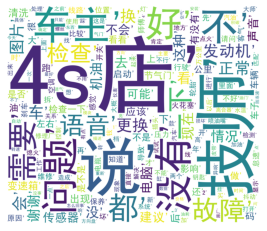

In [114]:
wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2,font_path=zhfont).generate(str(wordlist))
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [115]:
wordcloud.to_file('wordcloud.png')  # 把词云保存下来

## Split the data

In [116]:
train_df['X'] = train_df[['Question', 'Dialogue']].apply(lambda x: ' '.join(x), axis=1)
test_df['X'] = test_df[['Question', 'Dialogue']].apply(lambda x: ' '.join(x), axis=1)

## Padding

In [118]:
def get_max_len(data):
    """
    获得合适的最大长度值
    :param data: 待统计的数据  train_df['Question']
    :return: 最大长度值
    """
    max_lens = data.apply(lambda x: x.count(' '))
    return int(np.mean(max_lens) + 2 * np.std(max_lens))
# 获取输入数据 适当的最大长度
train_y_max_len = get_max_len(train_df['X'])
test_y_max_len = get_max_len(test_df['X'])

x_max_len = max(train_y_max_len, test_y_max_len)

# 获取标签数据 适当的最大长度
train_y_max_len = get_max_len(train_df['Report'])

In [119]:
x_max_len

413

In [120]:
train_y_max_len

33

In [121]:
def pad_proc(sentence, max_len, vocab):
    '''
    # 填充字段
    < start > < end > < pad > < unk > max_lens
    '''
    # 0.按空格统计切分出词
    words = sentence.strip().split(' ')
    # 1. 截取规定长度的词数
    words = words[:max_len]
    # 2. 填充< unk > ,判断是否在vocab中, 不在填充 < unk >
    sentence = [word if word in vocab else '<UNK>' for word in words]
    # 3. 填充< start > < end >
    sentence = ['<START>'] + sentence + ['<STOP>']
    # 4. 判断长度，填充　< pad >
    sentence = sentence + ['<PAD>'] * (max_len - len(words))
    return ' '.join(sentence)
 
   
# 使用GenSim训练得出的vocab
vocab = model.wv.vocab
 
# 获取适当的最大长度
train_x_max_len = get_max_len(train_df['X'])
test_X_max_len = get_max_len(test_df['X'])
X_max_len = max(train_x_max_len, test_X_max_len)
train_df['X'] = train_df['X'].apply(lambda x: pad_proc(x, X_max_len, vocab))
 
# 获取适当的最大长度
test_df['X'] = test_df['X'].apply(lambda x: pad_proc(x, X_max_len, vocab))
 
# 获取适当的最大长度
train_y_max_len = get_max_len(train_df['Report'])
train_df['Y'] = train_df['Report'].apply(lambda x: pad_proc(x, train_y_max_len, vocab))

In [122]:
# 保存中间结果数据
train_x_pad_path="train_x_pad"
train_y_pad_path="train_y_pad"
test_x_pad_path="test_x_pad"
train_df['X'].to_csv(train_x_pad_path, index=None, header=False)
train_df['Y'].to_csv(train_y_pad_path, index=None, header=False)
test_df['X'].to_csv(test_x_pad_path, index=None, header=False)

## Update vocab

In [123]:
print('start retrain w2v model')
model.build_vocab(LineSentence(train_x_pad_path), update=True)
model.train(LineSentence(train_x_pad_path), epochs=5, total_examples=model.corpus_count)
print('1/3')
model.build_vocab(LineSentence(train_y_pad_path), update=True)
model.train(LineSentence(train_y_pad_path), epochs=5, total_examples=model.corpus_count)
print('2/3')
model.build_vocab(LineSentence(test_x_pad_path), update=True)
model.train(LineSentence(test_x_pad_path), epochs=5, total_examples=model.corpus_count)
#保存词向量模型
model.save('new_word2vec_model')

start retrain w2v model
1/3
2/3


In [124]:
#更新vocab
vocab = {word: index for index, word in enumerate(model.wv.index2word)}
reverse_vocab = {index: word for index, word in enumerate(model.wv.index2word)}
# 更新词向量矩阵
embedding_matrix = model.wv.vectors
embedding_matrix.shape

(31937, 200)

## Transfer the word to data

In [125]:
# 遇到未知词就填充unk的索引
unk_index = vocab['<UNK>']
def transform_data(sentence,vocab):
    # 字符串切分成词
    words=sentence.split(' ')
    # 按照vocab的index进行转换
    ids=[vocab[word] if word in vocab else unk_index for word in words]
    return ids

In [126]:
# 将词转换成索引  [<START> 方向机 重 ...] -> [32800, 403, 986, 246, 231
train_ids_x=train_df['X'].apply(lambda x:transform_data(x,vocab))
train_ids_y=train_df['Y'].apply(lambda x:transform_data(x,vocab))
test_ids_x=test_df['X'].apply(lambda x:transform_data(x,vocab))
# 将索引列表转换成矩阵 [32800, 403, 986, 246, 231] --> array([[32800,   403,   986 ]]
train_data_X=np.array(train_ids_x.tolist())
train_data_Y=np.array(train_ids_y.tolist())
test_data_X=np.array(test_ids_x.tolist())

再次保存

In [127]:
train_x_pad_path="train_x_pad"
train_y_pad_path="train_y_pad"
test_x_pad_path="test_x_pad"
train_df['X'].to_csv(train_x_pad_path, index=None, header=False)
train_df['Y'].to_csv(train_y_pad_path, index=None, header=False)
test_df['X'].to_csv(test_x_pad_path, index=None, header=False)